# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

#### Устанавливаем необходимые библиотеки

In [ ]:
%%capture
%pip install typing-extensions==3.10.0.0 -q
%pip install tensorflow -q
%pip install --upgrade typeguard typing-extensions -q
%pip install ydata_profiling -q
%pip install pandas-profiling -q
%pip install typeguard==2.12.1 -q
%pip install transformers catboost optuna keras-tuner -q

#### Импортируем необходимые библиотеки согласно PEP-8

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import os
import pandas as pd
import numpy as np
from PIL import Image

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import ydata_profiling
import warnings
warnings.filterwarnings("ignore")

#### Загрузка данных

In [ ]:
# загружаем данные в переменные
DATA_FOLDER_PATH = 'C:\\Users\\ASUS\\Dropbox\\vs_code\\my_practicum_projects\\Модуль_5\\4. Сборный проект - 4\\'

# загружаем тренировочный датасет
NAME_TRAIN_DATASET = os.path.join(DATA_FOLDER_PATH, 'train_dataset.csv')

# загружаем тестовый датасет
NAME_TEST_DATASET = os.path.join(DATA_FOLDER_PATH, 'test_queries.csv')

# загружаем краудсорсинговые оценки в датасет
CROWD_DATASET =  os.path.join(DATA_FOLDER_PATH, 'CrowdAnnotations.tsv')

# загружаем экспертные оценки в датасет
EXPERT_DATASET =  os.path.join(DATA_FOLDER_PATH,  'ExpertAnnotations.tsv')

# загружаем тренировочные изображения в датасет
PATH_TRAIN_IMAGES = os.path.join(DATA_FOLDER_PATH, 'train_images')

# загружаем тестовые изображения в датасет
PATH_TEST_IMAGES = os.path.join(DATA_FOLDER_PATH, 'test_images')

In [ ]:
# Импорт датасета train
train_dataset_csv = pd.read_csv(NAME_TRAIN_DATASET)

In [ ]:
#сщздаём путь тестовому файлу с фото и сохраняем в переменную absolute_path
#absolute_path = r'C:\Users\ASUS\Dropbox\vs_code\my_practicum_projects\Модуль_5\4. Сборный проект - 4\test_queries.csv'

In [ ]:
test_dataset_csv = pd.read_csv(NAME_TEST_DATASET,sep='|',index_col = 0)

In [ ]:
# Импорт датасета test
#test_dataset_csv = pd.read_csv(absolute_path, index_col=[0], sep='|')

In [ ]:
# выводим датасет на экран
test_dataset_csv.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

#### Проверяем импорт датасета и выводим на экран 5 строк

In [ ]:
train_dataset_csv.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Создадим новые переменые и загрузим в них датасеты с оценками получеными в результате краудсорсинга и экспертные оценки.

In [ ]:
# оценки краудсорсинга
file_path = CROWD_DATASET
CrowdAnnotations = pd.read_csv(file_path, sep='\t')
columns_list = ['image','query','first_grade','second_grade','third_grade']
CrowdAnnotations.columns = columns_list
CrowdAnnotations.head()

image                        query  first_grade  \
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2          0.0   

   second_grade  third_grade  
0             0            3  
1             0            3  
2             0            3  
3             0            3  
4             0            3

In [ ]:
# оценки экспертов
file_path = EXPERT_DATASET
ExpertAnnotations = pd.read_csv(file_path, sep='\t')
columns_list = ['image','query','first_grade','second_grade','third_grade']
ExpertAnnotations.columns = columns_list
ExpertAnnotations.head()

image                        query  first_grade  \
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2            1   
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2            1   
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2            1   
3  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2            1   
4  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2            1   

   second_grade  third_grade  
0             1            2  
1             1            2  
2             2            2  
3             1            2  
4             1            1

`Вывод:` Для оценки достоверности соответствия картинки описанию, считаю целесообразным воспользоваться экспертными оценками, тк они представляют по-сути собой градиентную шкалу от 1 до 4, где 1 - изображение совершенно не соответсьвует описанию, а 4 - запрос и ответ полностью соответствуют.

Добавим в наш датасет новый признак - средняя экспертная оценка, а также вероятность сообтветствия описания и картинки.

In [ ]:
# новый параметр 'mean_grade' со средним значением экспертной оценки
ExpertAnnotations['mean_grade'] = ExpertAnnotations[['first_grade','second_grade','third_grade']].mean(axis=1)

In [ ]:
# новый параметр 'proportion' с долей людей, подтвердивших, что описание соответствует изображению.
# где 0 - описание не соответствует совсем, 1 - полностью соответствует.
ExpertAnnotations['proportion'] = (ExpertAnnotations['mean_grade'] - 1) / 3

In [ ]:
# выводим новый датасетс новыми признаками
ExpertAnnotations.head()

image                        query  first_grade  \
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2            1   
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2            1   
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2            1   
3  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2            1   
4  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2            1   

   second_grade  third_grade  mean_grade  proportion  
0             1            2    1.333333    0.111111  
1             1            2    1.333333    0.111111  
2             2            2    1.666667    0.222222  
3             1            2    1.333333    0.111111  
4             1            1    1.000000    0.000000

`Вывод:` Осуществили импорт библиотек и загрузку данных.

сохранили в переменные и вывели на экран тестовый и тренировочный датасеты изображениями и текстовыми описаниями картинки. Также вывели на экран дадасеты с экспертными и обывательскими оценками.

Для полноты информации и лучшей работы модели ввели новый признак: 'proportion' с долей людей, подтвердивших, что описание соответствует изображению.

Данные подготовлены к ИАД.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


#### Выводим подробную информацию о экспертных и краудсорсных оценок

In [ ]:
profile_expert = ExpertAnnotations.profile_report()
profile_crowd = CrowdAnnotations.profile_report()

Информация по экспертным оценкам

In [ ]:
profile_expert

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Инфорация по краудсорсным оценкам

In [ ]:
profile_crowd

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Проверяем уникальные значения и пропуски в тренировочном датасете

In [ ]:
print('Количество уникальных изображений в Трейне: ', train_dataset_csv['image'].value_counts().count())
print('Нулевые значения (пропуски):', train_dataset_csv['image'].isna().sum())

Количество уникальных изображений в Трейне:  1000
Нулевые значения (пропуски): 0


Проверяем уникальные значения и пропуски в тестовом датасете

In [ ]:
test_df = pd.read_csv(NAME_TEST_DATASET, sep='|', index_col = 0)
print('Количество уникальных изображений в Тесте: ', test_df['image'].value_counts().count())
print('Нулевые значения (пропуски):', test_df['image'].isna().sum())

Количество уникальных изображений в Тесте:  100
Нулевые значения (пропуски): 0


`Вывод:`

- Экспертные оценки: 5821 наблюдений без пропусков и дубликатов.
- Краудсорсные оценки: 47829 наблюдений без пропусков и дубликатов.
- Тренировочный датасет: 1000 уникальных значений и нет пропусков
- Тестовый датасет: 100 уникальных значений и нет пропусков

#### Выводим на экран изображения из тренировочного и тестового набора

Тренировочные изображения


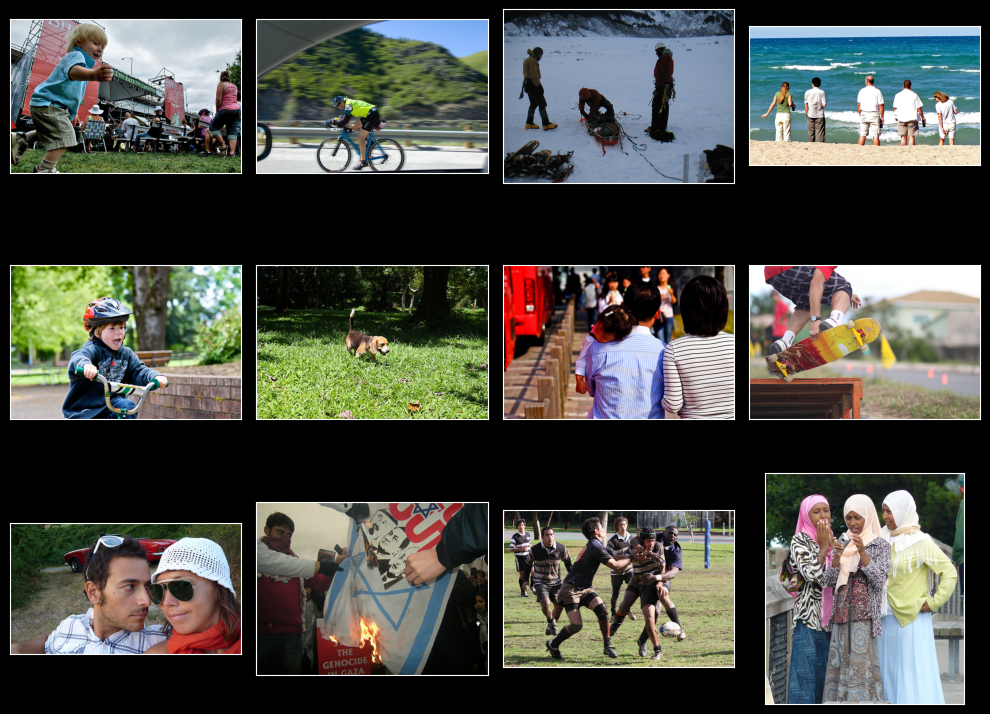

In [ ]:
train_photos = list(train_dataset_csv['image'].sample(12))

print('Тренировочные изображения')

fig_train = plt.figure(figsize=(10, 10))
for i in range(12):
    image_path = os.path.join(os.path.join(DATA_FOLDER_PATH, 'train_images'), train_photos[i])
    fig_train.add_subplot(4, 4, i + 1)
    plt.imshow(Image.open(image_path))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show()

Тестовые изображения


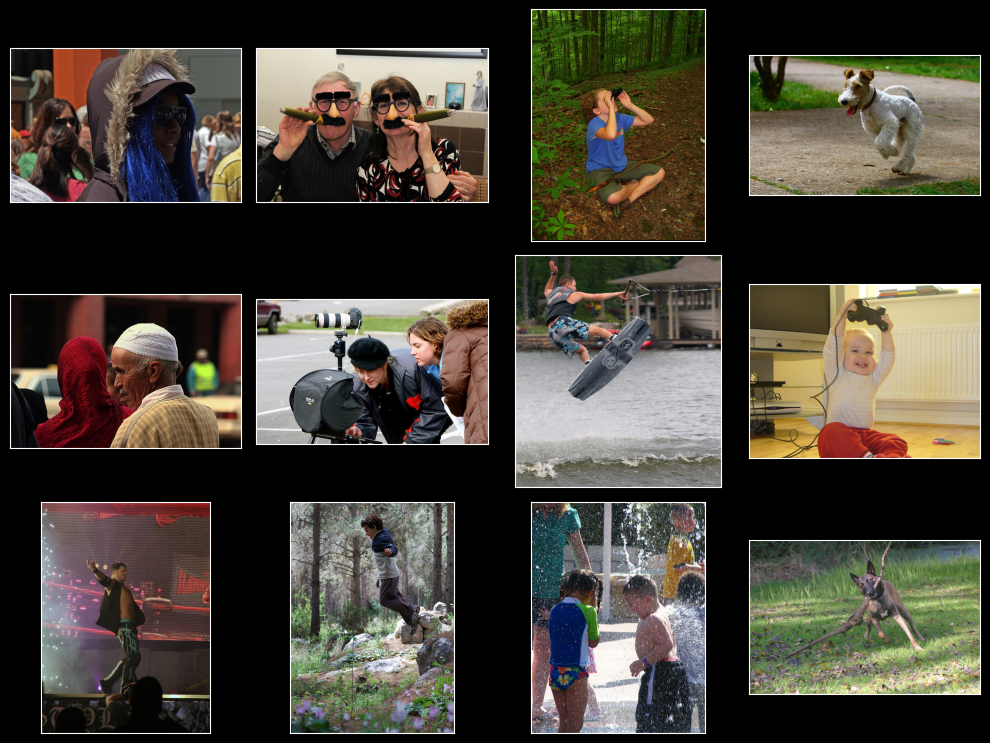

In [ ]:
test_photos = list(test_dataset_csv['image'].sample(12))

print('Тестовые изображения')

fig_test = plt.figure(figsize=(10, 10))
for i in range(12):
    image_path = os.path.join(os.path.join(DATA_FOLDER_PATH, 'test_images'), test_photos[i])
    fig_test.add_subplot(4, 4, i + 1)
    plt.imshow(Image.open(image_path))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

`Вывод:` врезультате исследовательского аналза данных были найдены размеры выборок, получена информация об отсутствии пропусков и дубликатов в датасетах.

Были просмотрены примеры изображений из тенировочного и тестового датасетов.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Составим список ключевых слов по котрым мы будем идентифецировать изображения с детьми чтобы исключить их из выборки для соответствия правилам исследования.

In [ ]:
# список ключевых слов
blockwords = [
    'boy',
    'girl',
    'child',
    'baby',
    'kid',
    'babe',
    'infant',
    'teenager',
    'teenage',
    'teeny',
    'juvenile',
    'teener',
    'young',
    'younger',
    'youngest',
    'youngster',
    'stripling',
    'schoolchild',
    'schoolboy',
    'schoolgirl'
]

In [ ]:
train_dataset_csv.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Отбираем и сохраняем уникальные значения в тдатасет

In [ ]:
df = train_dataset_csv[['query_id','query_text']].drop_duplicates()
df = df.reset_index(drop=True)

Лемматизируем тексты

In [ ]:
# токенизация
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()

# лемматизируем
lemmatizer = nltk.stem.WordNetLemmatizer()

# функция лемматизации
def lemmatized_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenizer.tokenize(text)]
df['query_text_lemma'] = df['query_text'].apply(lemmatized_text)

Удаляем записи с ключевыми словами чтобы избавиться от изображений которые должны быть удалены.

In [ ]:
# применяем метод 'apply' чтобы отфильтровать необходимые значения
df = df[df['query_text_lemma'].apply(lambda x: not any(word in x for word in blockwords))]

# сохраняем обратно в датафрейм
df = df.reset_index(drop=True)

In [ ]:
df.head()

query_id  \
0  3181701312_70a379ab6e.jpg#2   
1  3207358897_bfa61fa3c6.jpg#2   
2  3286822339_5535af6b93.jpg#2   
3  3360930596_1e75164ce6.jpg#2   
4   434792818_56375e203f.jpg#2   

                                          query_text  \
0    A man sleeps under a blanket on a city street .   
1  A woman plays with long red ribbons in an empt...   
2         Chinese market street in the winter time .   
3  A soccer ball is above the head of a man weari...   
4  A man and woman look back at the camera while ...   

                                    query_text_lemma  
0  [A, man, sleep, under, a, blanket, on, a, city...  
1  [A, woman, play, with, long, red, ribbon, in, ...  
2  [Chinese, market, street, in, the, winter, tim...  
3  [A, soccer, ball, is, above, the, head, of, a,...  
4  [A, man, and, woman, look, back, at, the, came...

Пометим прошедшие "ценз" изображения как согласованные 'Approved'

In [ ]:
df['label'] = 'Approved'
df.head()

query_id  \
0  3181701312_70a379ab6e.jpg#2   
1  3207358897_bfa61fa3c6.jpg#2   
2  3286822339_5535af6b93.jpg#2   
3  3360930596_1e75164ce6.jpg#2   
4   434792818_56375e203f.jpg#2   

                                          query_text  \
0    A man sleeps under a blanket on a city street .   
1  A woman plays with long red ribbons in an empt...   
2         Chinese market street in the winter time .   
3  A soccer ball is above the head of a man weari...   
4  A man and woman look back at the camera while ...   

                                    query_text_lemma     label  
0  [A, man, sleep, under, a, blanket, on, a, city...  Approved  
1  [A, woman, play, with, long, red, ribbon, in, ...  Approved  
2  [Chinese, market, street, in, the, winter, tim...  Approved  
3  [A, soccer, ball, is, above, the, head, of, a,...  Approved  
4  [A, man, and, woman, look, back, at, the, came...  Approved

In [ ]:
train_dataset_csv.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Объединяем таблицы

In [ ]:
train_dataset_csv = train_dataset_csv.merge(df, on='query_id', how='left')

Проверяем результат и выводим на экран

In [ ]:
display(train_dataset_csv.head())
print(train_dataset_csv.shape)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                        query_text_x query_text_y  \
0  A young child is wearing blue goggles and sitt...          NaN   
1  A young child is wearing blue goggles and sitt...          NaN   
2  A young child is wearing blue goggles and sitt...          NaN   
3  A young child is wearing blue goggles and sitt...          NaN   
4  A young child is wearing blue goggles and sitt...          NaN   

  query_text_lemma label  
0              NaN   NaN  
1              NaN   NaN  
2              NaN   NaN  
3              NaN   NaN  
4              NaN   NaN

(5822, 6)


Тепрерь удалим строки где нет пометки 'approved' в признаке 'lable' и оставим в таблице только строки с изображениями прошедшими наш ценз.

In [ ]:
train_dataset_csv_photos = train_dataset_csv[train_dataset_csv['label'] == 'Approved']

Проверяем результат и выводим на экран таблицу с удалёнными фото

In [ ]:
# предпросмотр таблицы
display(train_dataset_csv_photos.head())

# размер таблицы
print('Размер таблицы: ', train_dataset_csv_photos.shape)

image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                       query_text_x  \
22  A man sleeps under a blanket on a city street .   
23  A man sleeps under a blanket on a city street .   
24  A man sleeps under a blanket on a city street .   
25  A man sleeps under a blanket on a city street .   
26  A man sleeps under a blanket on a city street .   

                                       query_text_y  \
22  A man sleeps under a blanket on a city street .   
23  A man sleeps under a blanket on a city street .   
24  A man sleeps under a blanket on a city street .   
25  A man sleeps under a blanket on a city street .   
26  A man sleeps under a blanket on a city street .   

                                     query_text_lemma     label  
22  [A, man, sleep, under, a, blanket, on, a, city...  Approved  
23  [A, man, sleep, under, a, blanket, on, a, city...  Approved  
24  [A, man, sleep, under, a, blanket, on, a, city...  Approved  
25  [A, man, sleep, under, a, blanket, on, a, city...  Approved  
26  [A, man, sleep, under, a, blanket, on, a, city...  Approved

Размер таблицы:  (4284, 6)


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
df_train_images = pd.DataFrame(train_dataset_csv_photos.image.unique(), columns=['image'])
df_train_images

image
0    1056338697_4f7d7ce270.jpg
1    3187395715_f2940c2b72.jpg
2     463978865_c87c6ca84c.jpg
3     488590040_35a3e96c89.jpg
4     534875358_6ea30d3091.jpg
..                         ...
989  2559921948_06af25d566.jpg
990  2718495608_d8533e3ac5.jpg
991  3523474077_16e14bc54c.jpg
992   476759700_8911f087f8.jpg
993  3399284917_721aefe2a7.jpg

[994 rows x 1 columns]

Создаём иренировочный датасет

In [ ]:

datagen_train = ImageDataGenerator(rescale=1.0/255)
train_datagen_flow = datagen_train.flow_from_dataframe(
    dataframe = df_train_images,
    directory=PATH_TRAIN_IMAGES,
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=24,
    shuffle=False,
    seed=123
)


Found 994 validated image filenames.


In [ ]:
# создаём features
features = next(train_datagen_flow)

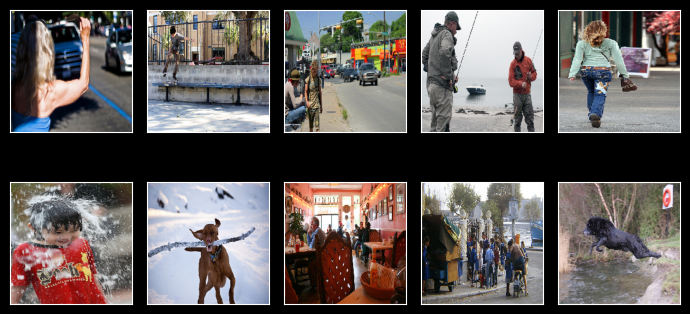

In [ ]:
# Выводим на экран features
fig = plt.figure(figsize=(7, 5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Производим векторизацию при помощи ResNet50

In [ ]:
backbone = ResNet50(weights='imagenet',
                    include_top=False)
backbone.trainable = False

In [ ]:
model_image = Sequential()
model_image.add(backbone)
model_image.add(GlobalAveragePooling2D())

image_features = model_image.predict(train_datagen_flow)

42/42 [==============================] - 108s 3s/step


In [ ]:
df_train_images_with_vectors = pd.concat([df_train_images, pd.DataFrame(image_features)], axis=1)
df_train_images_with_vectors

image    0    1         2    3         4    5    6  \
0    1056338697_4f7d7ce270.jpg  0.0  0.0  0.007830  0.0  1.220195  0.0  0.0   
1    3187395715_f2940c2b72.jpg  0.0  0.0  0.000000  0.0  1.266020  0.0  0.0   
2     463978865_c87c6ca84c.jpg  0.0  0.0  0.006961  0.0  1.234630  0.0  0.0   
3     488590040_35a3e96c89.jpg  0.0  0.0  0.006247  0.0  1.190135  0.0  0.0   
4     534875358_6ea30d3091.jpg  0.0  0.0  0.000000  0.0  1.152797  0.0  0.0   
..                         ...  ...  ...       ...  ...       ...  ...  ...   
989  2559921948_06af25d566.jpg  0.0  0.0  0.021651  0.0  0.908439  0.0  0.0   
990  2718495608_d8533e3ac5.jpg  0.0  0.0  0.000000  0.0  1.339223  0.0  0.0   
991  3523474077_16e14bc54c.jpg  0.0  0.0  0.000413  0.0  1.179031  0.0  0.0   
992   476759700_8911f087f8.jpg  0.0  0.0  0.015899  0.0  1.448190  0.0  0.0   
993  3399284917_721aefe2a7.jpg  0.0  0.0  0.000000  0.0  0.729332  0.0  0.0   

            7         8  ...  2038  2039  2040  2041      2042  2043  2044  \
0    0.931981  0.017054  ...   0.0   0.0   0.0   0.0  0.011325   0.0   0.0   
1    0.959061  0.031962  ...   0.0   0.0   0.0   0.0  0.048288   0.0   0.0   
2    0.916309  0.016477  ...   0.0   0.0   0.0   0.0  0.044525   0.0   0.0   
3    0.918404  0.019437  ...   0.0   0.0   0.0   0.0  0.035228   0.0   0.0   
4    0.751597  0.007979  ...   0.0   0.0   0.0   0.0  0.042854   0.0   0.0   
..        ...       ...  ...   ...   ...   ...   ...       ...   ...   ...   
989  0.777507  0.028406  ...   0.0   0.0   0.0   0.0  0.006550   0.0   0.0   
990  0.971337  0.023766  ...   0.0   0.0   0.0   0.0  0.018247   0.0   0.0   
991  0.950052  0.001239  ...   0.0   0.0   0.0   0.0  0.037312   0.0   0.0   
992  0.819962  0.005010  ...   0.0   0.0   0.0   0.0  0.044603   0.0   0.0   
993  0.725777  0.015403  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   

         2045  2046  2047  
0    2.164480   0.0   0.0  
1    2.228358   0.0   0.0  
2    2.145982   0.0   0.0  
3    1.908759   0.0   0.0  
4    2.271279   0.0   0.0  
..        ...   ...   ...  
989  1.915310   0.0   0.0  
990  2.012743   0.0   0.0  
991  2.059094   0.0   0.0  
992  2.293139   0.0   0.0  
993  2.374245   0.0   0.0  

[994 rows x 2049 columns]

`Вывод:` Мы создали датафрейм в котором каждому изображению соответствует вектор.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Используя Natural Language Toolkit (nltk) скачиваем

In [ ]:
nltk.download('blockwords')
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Error loading blockwords: Package 'blockwords' not found
[nltk_data]     in index


Пооводим векторизацию текстов

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(df['query_text'])
tf_idf = tf_idf.toarray()

Создаём новый датафрейм

In [ ]:
df_tfidf = pd.DataFrame(tf_idf)
df_tfidf['query_id'] = df['query_id']

Объединяем таблицы, добавляем вектора текстов

In [ ]:
df_train_text = train_dataset_csv.merge(df_tfidf, on='query_id', how='left')

Выводим таблицу

In [ ]:
df_train_text.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                        query_text_x query_text_y  \
0  A young child is wearing blue goggles and sitt...          NaN   
1  A young child is wearing blue goggles and sitt...          NaN   
2  A young child is wearing blue goggles and sitt...          NaN   
3  A young child is wearing blue goggles and sitt...          NaN   
4  A young child is wearing blue goggles and sitt...          NaN   

  query_text_lemma label   0   1   2   3  ...  1138  1139  1140  1141  1142  \
0              NaN   NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
1              NaN   NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
2              NaN   NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
3              NaN   NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
4              NaN   NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   

   1143  1144  1145  1146  1147  
0   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN  

[5 rows x 1154 columns]

`Вывод:` Мы создали и добавили векторы к текстам

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
data = df_train_text.merge(df_train_images_with_vectors, on='image')
data['key'] = data['image'] + data['query_id']

In [ ]:
ExpertAnnotations = ExpertAnnotations[['image', 'query', 'proportion']]
ExpertAnnotations = ExpertAnnotations.drop_duplicates()
ExpertAnnotations.head()

image                        query  proportion
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.111111
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    0.111111
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    0.222222
3  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    0.111111
4  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2    0.000000

Создаём ключевой признак по которому будем объединять таблицы

In [ ]:
ExpertAnnotations['key'] = ExpertAnnotations['image'] + ExpertAnnotations['query']

Объединяем таблицы

In [ ]:
data = data.merge(ExpertAnnotations, on='key', how='left')

# выводим размер объединённой таблицы
data.shape

(5789, 3206)

Выводим готовую таблицу

In [ ]:
data.head()

image_x                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                        query_text_x  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                        query_text_y  \
0                                                NaN   
1                                                NaN   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                    query_text_lemma     label  0_x  1_x  2_x  \
0                                                NaN       NaN  NaN  NaN  NaN   
1                                                NaN       NaN  NaN  NaN  NaN   
2  [A, man, sleep, under, a, blanket, on, a, city...  Approved  0.0  0.0  0.0   
3  [A, woman, play, with, long, red, ribbon, in, ...  Approved  0.0  0.0  0.0   
4  [Chinese, market, street, in, the, winter, tim...  Approved  0.0  0.0  0.0   

   3_x  ...      2042  2043  2044     2045  2046  2047  \
0  NaN  ...  0.011325   0.0   0.0  2.16448   0.0   0.0   
1  NaN  ...  0.011325   0.0   0.0  2.16448   0.0   0.0   
2  0.0  ...  0.011325   0.0   0.0  2.16448   0.0   0.0   
3  0.0  ...  0.011325   0.0   0.0  2.16448   0.0   0.0   
4  0.0  ...  0.011325   0.0   0.0  2.16448   0.0   0.0   

                                                 key  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9...   
1  1056338697_4f7d7ce270.jpg2718495608_d8533e3ac5...   
2  1056338697_4f7d7ce270.jpg3181701312_70a379ab6e...   
3  1056338697_4f7d7ce270.jpg3207358897_bfa61fa3c6...   
4  1056338697_4f7d7ce270.jpg3286822339_5535af6b93...   

                     image_y                        query  proportion  
0                        NaN                          NaN         NaN  
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.111111  
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    0.111111  
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    0.222222  
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    0.111111  

[5 rows x 3206 columns]

`Вывод:` мы получили объединённую таблицу и готовы к обучению модели

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

`Выбор метрики:` В нашем случае мы имеем дело в моделью регрессии тк экспертные оценки представляют собой грпдиентные значения. Для моделей регрессии подойдёт метрика RMSE.

In [ ]:
# смотрим на пропуски
print(data.isna().sum())
print(data.shape)

image_x                0
query_id               0
query_text_x           0
query_text_y        1505
query_text_lemma    1505
                    ... 
2047                   0
key                    0
image_y                1
query                  1
proportion             1
Length: 3206, dtype: int64
(5789, 3206)


In [ ]:
# удаляем строки с пропусками и делаем ресет индекса
data = data.dropna()
data = data.reset_index(drop=True)

In [ ]:
# выводим итоговый размер таблицы
data.shape

(4284, 3206)

In [ ]:
#заполним пропуск, средним значением
#data['proportion'].fillna(value=data['proportion'].mean(), inplace=True)

Производим разбивку датасетов при помощи GroupShuffleSplit

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

train_idx, valid_idx = next(gss.split(X=data.drop(columns=['image_x', 'query_id', 'query_text_x',]),
                                      y=data['proportion'],
                                      groups=data['proportion']))

train, valid = data.loc[train_idx], data.loc[valid_idx]

In [ ]:
features_train, target_train = train.drop(['image_x', 'proportion', 'query_id', 'query_text_x','query_text_y','query_text_lemma','label','key','image_y','query'], axis=1), train['proportion']
features_valid, target_valid = valid.drop(['image_x', 'proportion', 'query_id', 'query_text_x','query_text_y','query_text_lemma','label','key','image_y','query'], axis=1), valid['proportion']
features_train.columns = features_train.columns.astype(str)
features_valid.columns = features_valid.columns.astype(str)

In [ ]:
# заполняем средними значениями, пропуски в тренировочных данных чтобы модель могла работать
#imputer = SimpleImputer(strategy='mean')
#features_train_imputed = imputer.fit_transform(features_train)
#features_valid_imputed = imputer.transform(features_valid)

#### Обучаем нашу первую модель - Ridge

In [ ]:
# сохраняем модель в переменную
lr_model = Ridge(alpha=9)

# обучаем модель
lr_model.fit(features_train, target_train)

# высчитываем среднеквадратичную ошибку
mse = mean_squared_error(lr_model.predict(features_valid), target_valid)

# выводим квадратный корень среднеквадратической ошибки (RMSE)
print('RMSE: ', mse**0.5)

RMSE:  0.33473191782276945


`Вывод:` RMSE: 0.33473191782276945

#### Переходим к обучению второй модели: нейросеть

In [ ]:
features_train = torch.FloatTensor(features_train.values)
features_valid = torch.FloatTensor(features_valid.values)
target_train = torch.FloatTensor(target_train.values)
target_valid = torch.FloatTensor(target_valid.values)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(p=0.1)

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        return x
n_in_neurons = 3196
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 50

n_out_neurons = 1
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(features_train).flatten()
    loss_value = loss(target_train, preds)
    loss_value.backward()
    optimizer.step()
    if epoch % 2 == 0 :
        net.eval()
        test_preds = net.forward(features_valid)
        RMSE = torch.sqrt(loss(test_preds.flatten(),target_valid.flatten()))
        print(RMSE)
    net.train()

tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)
tensor(0.2149, grad_fn=<SqrtBackward0>)


`Вывод:` нейросеть показала лучшие результаты RMSE 0.2149 вместо 0.3347 как у модели Ridge.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
datagen_test = ImageDataGenerator(rescale=1.0/255)
test_datagen_flow = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=PATH_TEST_IMAGES,
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=150,
    shuffle=False,
    seed=1
)

Found 500 validated image filenames.


Производим векторизацию

In [ ]:
image_features_test = model_image.predict(test_datagen_flow)
df_test_image_features = pd.concat([test_df, pd.DataFrame(image_features_test)], axis=1)

4/4 [==============================] - 49s 10s/step


In [ ]:
queries_for_test = df_test_image_features['query_text'].sample(10, random_state=5)
queries_for_test = queries_for_test.reset_index(drop=True)

In [ ]:
df_test_image_features_for_cycle = df_test_image_features.copy()
df_test_image_features_for_cycle  = df_test_image_features_for_cycle.drop(['query_id','query_text','image'],axis=1)

Создаём функцию для проверки работы модели

In [ ]:
def testing_image(text):
    print(f'Описание: {text}')

    for word in text.split():
        if word in blockwords:
            return 'WARNING: This image is unavailable in your country in compliance with local laws.'
    text = pd.Series(text)
    best = 0
    best_index = 0
    pred_list = []
    df2 = pd.DataFrame(count_tf_idf.transform(text).toarray())

    for i in range(len(df_test_image_features)):
        curent_df = df_test_image_features_for_cycle.loc[i]
        curent_df = pd.DataFrame(curent_df).T.reset_index(drop=True)
        curent_df = pd.concat([curent_df] + [df2], axis=1)

        curent_predict = lr_model.predict(curent_df)
        pred_list.append(curent_predict)

        if curent_predict > best:
            best = curent_predict
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')

    # используем os.path.join чтобы создать путь
    image_path = os.path.join(PATH_TEST_IMAGES, df_test_image_features.image[best_index])

    print(f'Лучшее изображение:')
    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()
    print('----------------------------------------')


Проверяем функцию на десяти запросах

Описание: Two boys playing in water .
Лучшая вероятность: [0.37313846]
Лучший индекс: 345
Лучшее изображение:


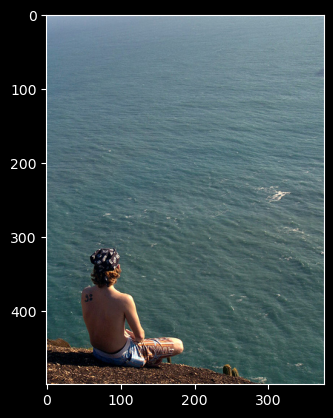

----------------------------------------
Описание: a boy runs through the grass .
Описание: A dog jumping off a dock into a pool of water .
Лучшая вероятность: [0.37604956]
Лучший индекс: 345
Лучшее изображение:


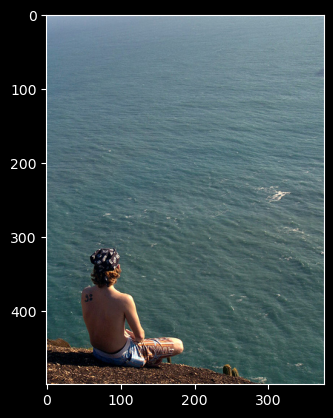

----------------------------------------
Описание: A brown dog is grabbing the collar of a black dog .
Лучшая вероятность: [0.35774388]
Лучший индекс: 345
Лучшее изображение:


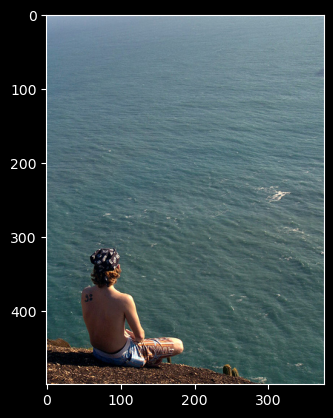

----------------------------------------
Описание: A black and white dog biting onto a chunk of ice .
Лучшая вероятность: [0.36713578]
Лучший индекс: 345
Лучшее изображение:


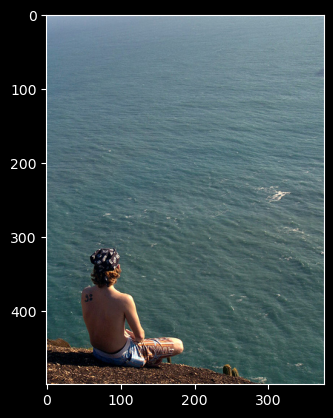

----------------------------------------
Описание: Two women , one with a head bandanna , are standing next to each other while one holds a bottle .
Лучшая вероятность: [0.36247369]
Лучший индекс: 345
Лучшее изображение:


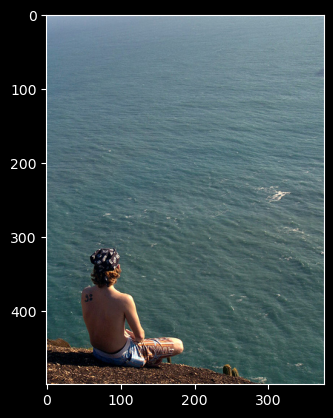

----------------------------------------
Описание: Two women in head wraps .
Лучшая вероятность: [0.36469876]
Лучший индекс: 345
Лучшее изображение:


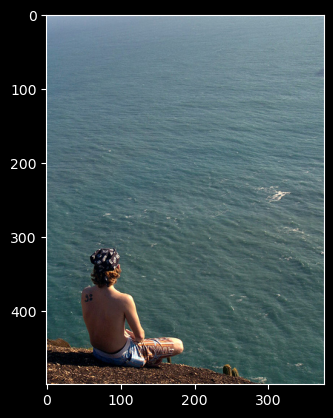

----------------------------------------
Описание: A girl in a bikini top and shorts poses for a picture on a mountain overlooking a lake .
Описание: A man is videotaping something .
Лучшая вероятность: [0.36722097]
Лучший индекс: 345
Лучшее изображение:


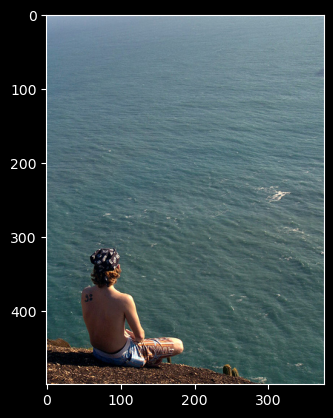

----------------------------------------


In [ ]:
for i in range(1, 10):
    testing_image(queries_for_test[i])

`Общий вывод:` В ходе исследования была сделана предобработка данных, выполнена векторирация.

Для обучения была использована модель Ridge и нейросеть. Лучший результат показала нейросеть RMSE 0.2149 вместо 0.3347 как у модели Ridge.

При помощи созданной функции мы продемонстрировали реальную работу модели.

Несмотря на хорошую метрику, модель работаем не так хорошо как ожидалось, возможной причиной, является недстаточность данных либо подход к решению и инструментарий должен быть иной.